In [1]:
from PIL import Image, ImageOps
import os, sys, shutil
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt 
%matplotlib inline

In [2]:
def process_image(nD,dirs,path,newpath):
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item).convert('RGB')
            f, e = os.path.splitext(path+item)
            imResize = im.resize((nD,nD), Image.ANTIALIAS)
            im_invert = ImageOps.invert(imResize)
            for i in range(0,30,2):
                im_rot = im_invert.rotate(-i)
                im_rot_w = im_invert.rotate(i)
                im_rot.save((newpath+item) +str(i)+ ' rotated.png', 'png', quality=90)
                im_rot_w.save((newpath+item) +str(i)+ ' rotated_w.png', 'png', quality=90)
                
def make_dataset(nD):
    dirs = os.listdir("dataset/")
    for i in range(0,10):
        if str(i) in dirs:
            shutil.rmtree("dataset/"+str(i))
    for i in range(0,10):
        path = "dataset_original/"+str(i)+"/"
        newpath = "dataset/"+str(i)+"/"
        os.makedirs(newpath)
        dirs = os.listdir( path )
        if ".DS_Store" in dirs:
            dirs.remove(".DS_Store")
        process_image(nD,dirs,path,newpath)

In [3]:
nD = 64  #number of image's dimension
make_dataset(nD)
print("loading dataset...")
data = []
label = []
data_fig = []
root_path = 'dataset/'
data_dir = range(0,10)
for d in data_dir:
    t = d
    f_list = os.listdir(root_path+str(d)+'/')
    if ".DS_Store" in f_list:
        f_list.remove(".DS_Store")
    for f in f_list:
        img = Image.open(root_path+str(d)+'/'+f).convert('L')
        img_array = np.asarray(img)
        data.append(img_array)
        data_fig.append(img)
        label.append(t)
        
data = np.array(data)/255.
data = data.reshape(data.shape[0],-1)
label = np.array(label)
X = data
y = label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
means = np.zeros((10, nD*nD))
cov = np.zeros((nD*nD, nD*nD))
print("dataset loaded!")

loading dataset...
dataset loaded!


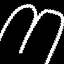

In [4]:
data_fig[543]

9


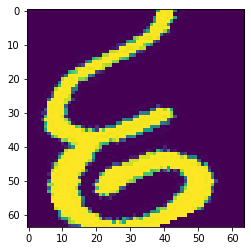

In [5]:
def vec2img(vec):
    vec = vec*255.
    vec = vec.reshape(nD,nD)
    return vec

test = vec2img(X_train[0])

plt.imshow(test)
print(y_train[0])

In [6]:
import time
means = np.zeros((10, nD*nD))
cov = np.zeros((nD*nD, nD*nD))
count = [sum(map(lambda x : x == i, y_train)) for i in range(0,10)]
start_time = time.time()
for i in range(10):
    cov_array = []
    for j in range(len(y_train)):
        if int(y_train[j]) == i:
            means[i] = means[i] + X_train[j]
            cov_array.append(X_train[j])
            
    cov = cov + np.cov(np.array(cov_array).T) * (1/10.)

means = means / len(y_train)
inv_cov = np.linalg.inv(cov + 0.00001*np.eye(nD*nD))
print("--- %s seconds ---" % (time.time() - start_time))

--- 21.8038649559021 seconds ---


In [7]:
ans = np.zeros((10, 10),dtype='int')
total = 0
errors = []

for i in range(10):
    for j in range(len(y_test)):
        if int(y_test[j]) == i:
            p = np.zeros(10)
            for k in range(len(p)):
                p[k] = np.dot(np.dot(means[k].T, inv_cov), X_test[j]) - (np.dot(np.dot(means[k].T, inv_cov), means[k])) / 2 + np.log(count[i])

            m = p.argmax()
            if m!=y_test[j]:
                errors.append((j,m))
            ans[m][int(y_test[j])] = int(ans[m][int(y_test[j])] + 1)

df = pd.DataFrame({'0': ans[0], '1': ans[1], '2': ans[2], '3': ans[3], '4': ans[4], '5': ans[5], '6': ans[6], '7': ans[7], '8': ans[8], '9': ans[9]},index=['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])
df.style.background_gradient(cmap='winter')

print(df)

    0   1   2   3   4   5   6   7   8   9
0  29   0   0   0   0   0   0   0   0   0
1   0  30   0   0   0   0   0   0   0   0
2   0   0  40   0   0   0   0   0   0   0
3   0   0   0  31   0   0   0   0   0   0
4   0   0   0   0  20   0   0   0   0   0
5   0   0   0   0   0  23   0   0   0   0
6   0   0   0   0   0   0  28   0   0   0
7   0   0   0   0   0   0   0  26   0   0
8   0   0   0   0   0   0   0   0  34   0
9   0   0   0   0   0   0   0   0   0  39


In [8]:
print(errors)
print(100-len(errors)/len(y_test)*100)

[]
100.0


In [9]:
for i in errors:
    print(y_test[i[0]])
    print(i[1])
    plt.imshow(vec2img(X_test[i[0]]))
    plt.show()

In [10]:
print(len(y_test),len(y_train))

300 1200
